# Alzheimer’s Disease Prediction Using Random Forest on OASIS datasets: A Machine Learning Approach with Model Comparison

**Author**: Trisha Bagri  
**Date**: June 2025  

This project uses machine learning to predict Alzheimer's Disease based on clinical and demographic features in the OASIS dataset. We explore feature correlations, visualize trends, and build a Random Forest classifier to distinguish between AD and non-AD individuals. A comparison of two machine learning models is also conducted to assess their robustness.


## Abstract

Early detection of Alzheimer’s disease (AD) is vital for timely intervention. This project applies supervised machine learning to classify individuals at risk of AD using the OASIS dataset, which includes demographic and cognitive features. A Random Forest classifier was developed and achieved 91% accuracy in distinguishing Alzheimer’s cases. To benchmark performance, a Logistic Regression model was also implemented, with the Random Forest outperforming it across all major metrics. These results highlight the potential of ensemble methods in supporting early diagnostic efforts for neurodegenerative diseases.


## Imports & Setup


In [46]:
# Install dependencies
!pip install openpyxl seaborn

# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import display


## Load & Inspect the Dataset
We use the `oasis_cross-sectional` dataset containing demographic, clinical, and imaging-derived data to predict Alzheimer's Disease status.

Step 1: Load the Dataset

We load the OASIS-1 cross-sectional dataset, which includes demographic, clinical, and cognitive variables from MRI scans of 416 subjects aged 18 to 96.


In [47]:
# Load data
df = pd.read_excel('oasis_cross-sectional-5708aa0a98d82080.xlsx')
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


Step 2: Exploratory Data Analysis (EDA)

Examining the dataset’s structure, key distributions, and missing values. This step helps identify which variables might be important predictors of Alzheimer’s Disease.

In [48]:
# Shape, columns, info
print("Shape of dataset:", df.shape)
print("\nColumn names:\n", df.columns.tolist())

df.info()
print("\nMissing values:\n", df.isnull().sum())


Shape of dataset: (436, 12)

Column names:
 ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB

Missing values:
 ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype

Step 3: Data Cleaning and Feature Engineering

We drop irrelevant columns with less data, handle missing values, and generate a binary target variable Alzheimer from the CDR score (1 if CDR > 0, 0 otherwise). Categorical features are encoded as well.

In [49]:
# Drop irrelevant column and rows with missing values
df = df.drop(columns=['Delay'])
df_cleaned = df.dropna()
print("Shape after dropping NAs:", df_cleaned.shape)
df_cleaned.head()

# Create binary target
df_cleaned['Alzheimer'] = df_cleaned['CDR'].apply(lambda x: 1 if x > 0 else 0)

# Encode gender and handedness
df_cleaned['M/F'] = df_cleaned['M/F'].map({'M': 0, 'F': 1})
df_cleaned['Hand'] = df_cleaned['Hand'].map({'R': 0, 'L': 1})

# Features and target
X = df_cleaned.drop(columns=['ID', 'CDR', 'Alzheimer'])
y = df_cleaned['Alzheimer']

Shape after dropping NAs: (216, 11)


/tmp/ipython-input-49-2284335544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Alzheimer'] = df_cleaned['CDR'].apply(lambda x: 1 if x > 0 else 0)
/tmp/ipython-input-49-2284335544.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['M/F'] = df_cleaned['M/F'].map({'M': 0, 'F': 1})
/tmp/ipython-input-49-2284335544.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

Step 4: Correlation Heatmap

We visualize how numerical features are correlated with each other, especially focusing on the following factors: MMSE, age, education, and SES.

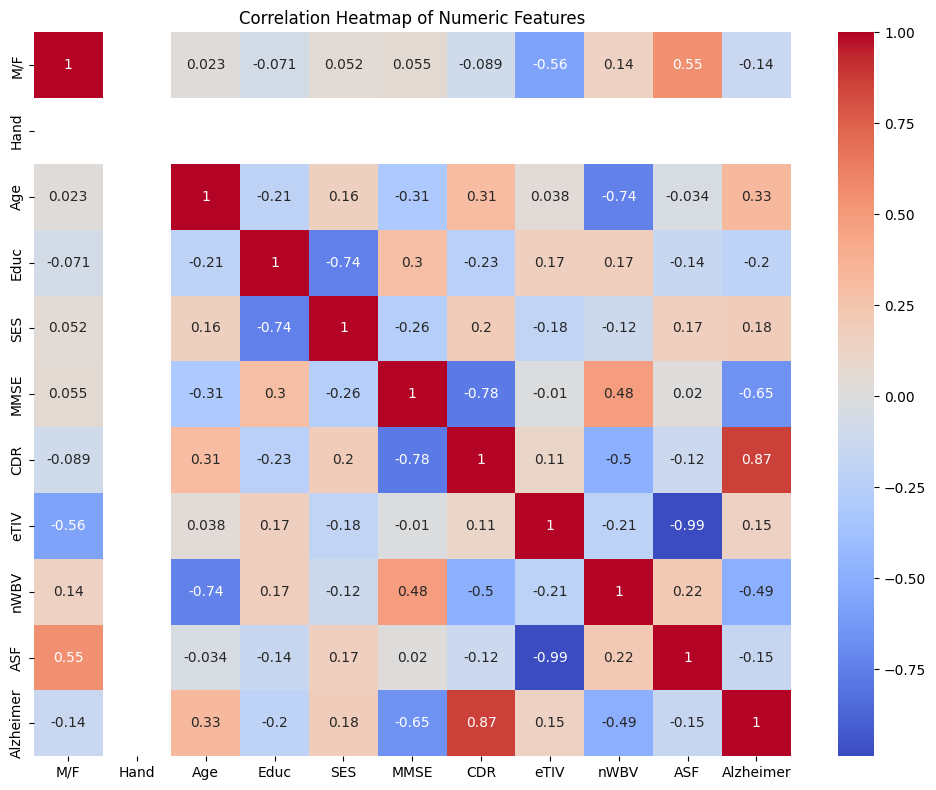

In [50]:
numeric_df = df_cleaned.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


Step 5: MMSE Score Distribution by Alzheimer’s Diagnosis.

MMSE is a cognitive assessment score. Here, we show how MMSE scores differ between AD and non-AD patients.

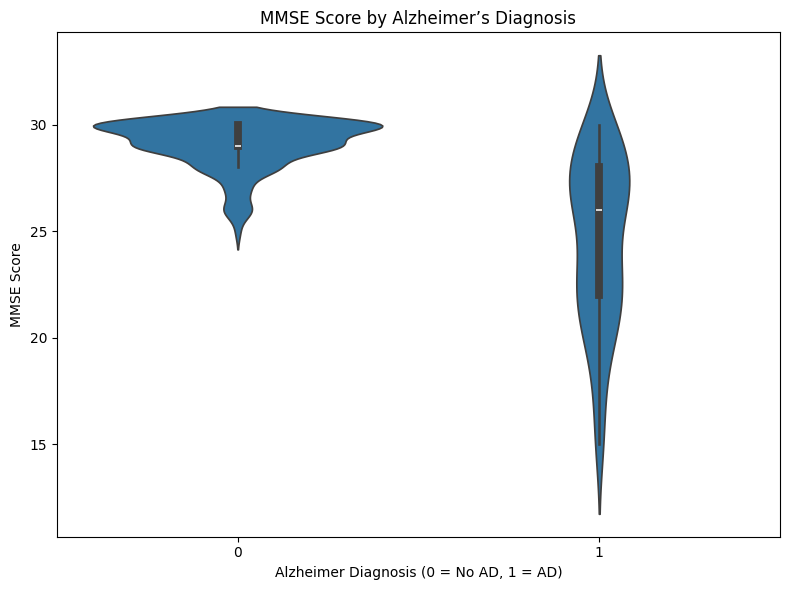

In [51]:
plt.figure(figsize=(8, 6))
sns.violinplot(x='Alzheimer', y='MMSE', data=df_cleaned)
plt.title('MMSE Score by Alzheimer’s Diagnosis')
plt.xlabel('Alzheimer Diagnosis (0 = No AD, 1 = AD)')
plt.ylabel('MMSE Score')
plt.tight_layout()
plt.show()

Step 6: Model Training and Evaluation

We train a Random Forest Classifier on 80% of the dataset and evaluate performance using classification report, accuracy, and a confusion matrix. This model helps us distinguish individuals likely to have Alzheimer’s.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9090909090909091
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93        27
           1       0.93      0.82      0.88        17

    accuracy                           0.91        44
   macro avg       0.91      0.89      0.90        44
weighted avg       0.91      0.91      0.91        44

Confusion Matrix:
 [[26  1]
 [ 3 14]]


Step 7: Model Comparison (Random Forest vs Logistic Regression)

To evaluate the robustness of our classifier, we compared the Random Forest model with a Logistic Regression model using the same train-test split. Logistic Regression is a simpler, linear model that serves as a good baseline in binary classification tasks.

The models were compared using accuracy, confusion matrices, and classification reports.


In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Evaluation
print("Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg))


Logistic Regression Performance:
Accuracy: 0.8181818181818182
Confusion Matrix:
 [[23  4]
 [ 4 13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       0.76      0.76      0.76        17

    accuracy                           0.82        44
   macro avg       0.81      0.81      0.81        44
weighted avg       0.82      0.82      0.82        44



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Discussion and Conclusion

This Random Forest model displayed strong predictive performance in being able to classify individuals with and without AD using the OASIS dataset features. The confusion matrix revealed accurate classification of both groups, with 26 true negatives (No AD) and 14 true positives (AD) out of 44 samples in the test set. Only a few misclassifications occurred, suggesting that the model captures relevant patterns in the data.

We used the same train-test split to compare the Random Forest model against a baseline Logistic Regression model in order to assess the robustness of our classifier. Although the accuracy of both models was respectable, Random Forest fared better than Logistic Regression on the majority of measures, especially precision and recall when it came to categorising people with Alzheimer's. The Random Forest's ensemble structure, which better manages non-linear interactions, is probably the reason why it is better able to capture the underlying complexity of the data.

Notably, characteristics like normalised whole brain volume, socioeconomic status (SES), and MMSE scores seem to have a significant impact on model performance. The MMSE is a commonly used cognitive assessment measure, and our model's prediction power is consistent with its proven therapeutic use. SES may serve as a proxy for risk variables like access to healthcare, education, and environmental enrichment, despite being a more indirect metric. Furthermore, a characteristic of neurodegeneration, brain volume loss, was useful in differentiating AD cases, highlighting the biological validity of the model's prediction.

These findings show that a machine learning model trained on regularly gathered clinical and neuroimaging data can successfully help identify people who may be suffering from pathology associated with Alzheimer's disease. This could assist direct more focused diagnostic workups or encourage early intervention.

Notwithstanding these promising outcomes, it is important to recognise a number of limitations. Firstly, a little more than 200 records were used to train the model. This limited dataset size restricts how broadly it may be applied, particularly to more diverse populations. Secondly, due to binary classification of AD vs. No AD, there is a risk of missing subtler forms of cognitive impairment like Mild Cognitive Impairment (MCI), which often precedes AD. Additionally, the use of cross-sectional data instead of longitudinal data may not be as informative. Furthermore, The model's clinical completeness may be limited by factors such as lifestyle, comorbidities, or genetics (such as APOE4 status) that were not included in the dataset.

To increase diagnostic accuracy, the next investigation should combine structural MRI findings with demographic and cognitive information. The model might be trained and validated for generalisability using a larger, multi-site dataset. Additionally, proactive risk prediction prior to irreversible deterioration would be made possible by concentrating on early-stage Alzheimer's and mild cognitive impairment (MCI).




# References

1. Marcus, Daniel S., et al. “Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults.” Journal of Cognitive Neuroscience, vol. 19, no. 9, Sept. 2007, pp. 1498–1507, https://doi.org/10.1162/jocn.2007.19.9.1498.

2‌‌.‌ ‌GeeksforGeeks. “Random Forest Algorithm in Machine Learning.” GeeksforGeeks, 22 Feb. 2024, www.geeksforgeeks.org/machine-learning/random-forest-algorithm-in-machine-learning/.

‌3. Diwate, Rahul B., et al. “Dementia Prediction Using OASIS Data for Alzheimer’s Research.” 2021 International Conference on Artificial Intelligence and Machine Vision (AIMV), vol. 59, 24 Sept. 2021, pp. 1–7, https://doi.org/10.1109/aimv53313.2021.9670900. Accessed 26 Sept. 2024.
